# Global AI Night - Credit Scoring

## Introduction

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. 

## The problem

Down below you will find a possible solution to the challenge described in [c/GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit) where participants where required to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years. The goal was to build a model that borrowers can use to help make the best financial decisions.

## The data

The training data contains the following variables:


| **Variable   Name**                  | **Description**                                                                                                                                              | **Type**   |
|--------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| SeriousDlqin2yrs                     | Person   experienced 90 days past due delinquency or worse                                                                                                   | *Y/N*      |
| RevolvingUtilizationOfUnsecuredLines | Total   balance on credit cards and personal lines of credit except real estate and   no installment debt like car loans divided by the sum of credit limits | percentage |
| age                                  | Age of borrower in   years                                                                                                                                   | integer    |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times   borrower has been 30-59 days past due but no worse in the last 2 years.                                                                    | integer    |
| DebtRatio                            | Monthly debt   payments, alimony,living costs divided by monthy gross income                                                                                 | percentage |
| MonthlyIncome                        | Monthly income                                                                                                                                               | real       |
| NumberOfOpenCreditLinesAndLoans      | Number of Open loans   (installment like car loan or mortgage) and Lines of credit (e.g. credit   cards)                                                     | integer    |
| NumberOfTimes90DaysLate              | Number of times   borrower has been 90 days or more past due.                                                                                                | integer    |
| NumberRealEstateLoansOrLines         | Number of mortgage   and real estate loans including home equity lines of credit                                                                             | integer    |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times   borrower has been 60-89 days past due but no worse in the last 2 years.                                                                    | integer    |
| NumberOfDependents                   | Number of dependents   in family excluding themselves (spouse, children etc.)                                                                                | integer    |

The **SeriousDlqin2yrs** is the dependent variable of the dataset, or better named the **label**. This is a boolean value which details if a certain individual has experienced a deliquency of 90 days past due or worse in the last 2 years.

You can get the training data from [here]().

This dataset should be used for:
- creating two smaller sets, one for the actual training (e.g. 80%) and one for testing (e.g. 20%)
- during cross validation, if you want to do the validation on multiple different folds of data to manage better the bias and the variance

The benchmark/real unseen data you could use to test your model predictions may be downloaded from [here]().

In [2]:
import numpy as np # library for linear algebra and stuff
import pandas as pd # library for data processing, I/O on csvs etc
import matplotlib.pyplot as plt # library for plotting
import seaborn as sns # a library which is better for plotting

# File location and type
file_location = "/FileStore/tables/constantscoring/cs_training-d35cb.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
trainingSDF = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

temp_table_name = "trainingSDF"

# Make the dataframe available in the SQL context
trainingSDF.createOrReplaceTempView(temp_table_name)

In [3]:
# Sample out 10 rows of the dataset
display(trainingSDF.sample(False, 0.1, seed=0).limit(10))

Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
21,0,0.200923382,43,0,0.430046338,12300,10,0,2,0,0
34,0,0.186868556,57,0,0.313812313,7000,9,0,2,0,0
40,0,0.304490668,52,0,0.808340474,3500,10,0,2,0,0
45,0,0.368875933,68,0,1687.5,1,31,0,1,0,0
49,0,0.834048027,38,0,0.393662026,13000,13,0,2,0,2
57,0,0.454971915,46,1,0.016921775,13000,10,0,0,0,1
84,0,0.054497069,56,0,0.492021814,4950,18,0,2,0,0
89,1,0.734477501,45,0,0.591477634,4716,13,0,2,0,2
96,0,0.24535301,37,0,0.288417167,6500,11,1,1,1,0
108,0,0.635415157,32,0,0.519493502,3000,4,0,1,0,1


In [4]:
# Inspect the schema
trainingSDF.printSchema()

root
-- Idx: integer (nullable = true)
-- SeriousDlqin2yrs: integer (nullable = true)
-- RevolvingUtilizationOfUnsecuredLines: double (nullable = true)
-- age: integer (nullable = true)
-- NumberOfTime30-59DaysPastDueNotWorse: integer (nullable = true)
-- DebtRatio: double (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- NumberOfOpenCreditLinesAndLoans: integer (nullable = true)
-- NumberOfTimes90DaysLate: integer (nullable = true)
-- NumberRealEstateLoansOrLines: integer (nullable = true)
-- NumberOfTime60-89DaysPastDueNotWorse: integer (nullable = true)
-- NumberOfDependents: integer (nullable = true)

In [5]:
# Check of the summary statistics of the features
display(trainingSDF.describe())

summary,Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000,150000,150000,150000,150000,150000,120269,150000,150000,150000,150000,146076
mean,75000.5,0.06684,6.048438054666814,52.295206666666665,0.4210333333333333,353.0050757638718,6670.221237392844,8.45276,0.26597333333333334,1.01824,0.24038666666666667,0.7572222678605657
stddev,43301.414526548666,0.24974553092871932,249.75537062543933,14.771865863100327,4.192781272018334,2037.8185231443642,14384.674215282088,5.145950989643263,4.169303787594452,1.1297709848828537,4.1551794209872375,1.1150860714871438
min,1,0,0.0,0,0,0.0,0,0,0,0,0,0
max,150000,1,50708.0,109,98,329664.0,3008750,58,98,54,98,20


Quick conclusions:
- there are a lot of null values for **MonthlyIncome** and **NumberOfDependents**; we will impute these with the median
- the minimum value for the **age** variable is 0 and it presents an outlier; this will be imputed with the median
- the maximum value of **329664** for the **DebtRatio** variable is rather weird given this variable is a mere percentage; from a modelling perspective, we are interested in values between 0 and 1, thus anything that surpasses 1 will likely be defaulted to this
- the maximum value of **50708** for the **RevolvingUtilizationOfUnsecuredLines** variable is rather weird given this variable is a mere percentage; from a modelling perspective, we are interested in values between 0 and 1, thus anything that surpasses 1 will be defaulted to this

## Data Visualization and Cleansing

We are going to take step by step most of the interesting columns that need visualizing and cleansing to be done.

### Target class - SeriousDlqin2yrs

Let's understand the distribution of our target class (**SeriousDlqin2yrs**). This could very well influence the algorithm we will want to use to model the problem.

In [8]:
%sql

select SeriousDlqin2yrs, count(*) as TotalCount from trainingSDF group by SeriousDlqin2yrs

SeriousDlqin2yrs,TotalCount
1,10026
0,139974


There seems to be a lot of **class imbalance** going on around here. Let's understand the positive event rate in our target class.

In [10]:
class_0 = trainingSDF.filter(trainingSDF.SeriousDlqin2yrs == 0).count()
class_1 = trainingSDF.filter(trainingSDF.SeriousDlqin2yrs == 1).count()

print("Total number of observations with a class of 0: {}".format(class_0))
print("Total number of observations with a class of 1: {}".format(class_1))
print("Positive event rate: {} %".format(class_1/(class_0+class_1) * 100))

Total number of observations with a class of 0: 139974
Total number of observations with a class of 1: 10026
Positive event rate: 6.683999999999999 %

A positive event rate of 6.68% is by no means ideal. Going through with this distribution for the target class will mean that the minorit class will be ignored by the algorithm we are going to use to model the problem, thus the model will be biased to customers which are not likely to default.

A couple of ideas which we are going to take into consideration going further to go around this problem:
- given we have a lot of training (100k observations), we may actually considering resampling the dataset using the **imbalanced-learn** module.
- we are going to use an evaluation metric which compensates the imbalance between classes, e.g. **AUC**
- we are going to consider using ensemble models and try out some penalized models (e.g. Logit)

### Age variable

We are interested in knowing the distribution of the **age** variable. Ideally, we would want this to be a normal distribution altogether.

We are also not looking for customers under the legal age of 18 years. If any, we will impute the age of these with the median of the column.

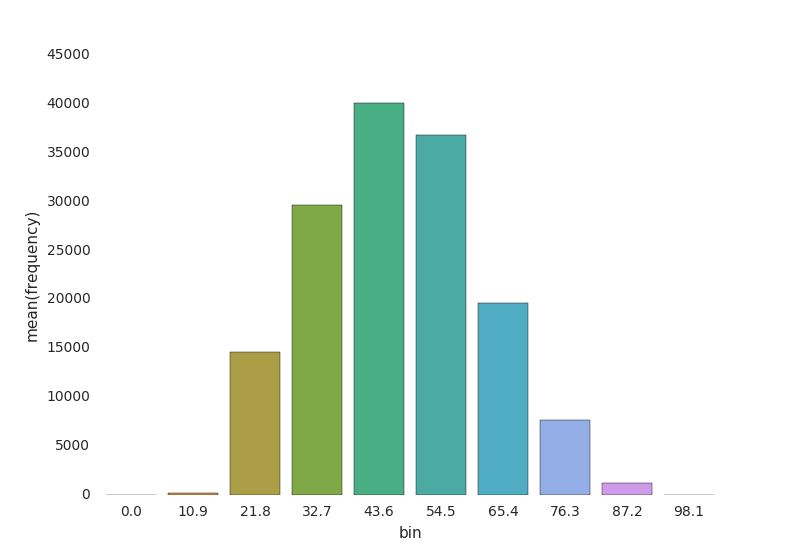

In [13]:
# spark.sql does not have any histogram method, however the RDD api does
age_histogram = trainingSDF.select('age').rdd.flatMap(lambda x: x).histogram(10)

fig, ax = plt.subplots()

# the computed histogram needs to be loaded in a pandas dataframe so we will be able to plot it using sns
age_histogram_df = pd.DataFrame(
    list(zip(*age_histogram)), 
    columns=['bin', 'frequency']
)

ax = sns.barplot(x = "bin", y = "frequency", data = age_histogram_df)

display(fig)

The distribution is close to normal which is fine for us.
However, it seems there may be customers under the legal age. Let's see how many.

In [15]:
# We can use the filter method to understand what are the observations for which the customers falls under the legal age.
display(trainingSDF.filter(trainingSDF.age < 18))

Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65696,0,0.9999999,0,1,0.436927179,6000,6,0,2,0,2


Fortunately there is only one. Let's impute this value with the median.

In [17]:
# Import functions which will help us code an if statement
from pyspark.sql import functions as F

def imputeAgeWithMedian(df):
  # Compute the median of the age variable
  ageMedian = np.median(
                  df.select('age')
                       .collect()
              )

  # Update the spark DataFrame with the median for the rows where the age column
  # is equal to 0
  df = df.withColumn('age',
                                       F.when(
                                           F.col('age') == 0,
                                           ageMedian
                                       ).otherwise(
                                           F.col('age')
                                       )
                )
  
  return df

trainingSDF = imputeAgeWithMedian(trainingSDF)

# Check to see that the only row shown above has a new age value
display(trainingSDF.filter(trainingSDF.Idx == 65696))

Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65696,0,0.9999999,52.0,1,0.436927179,6000,6,0,2,0,2


Finally, let's check the distribution of the age for each group, based on the values for the SeriousDlqin2yrs target variable

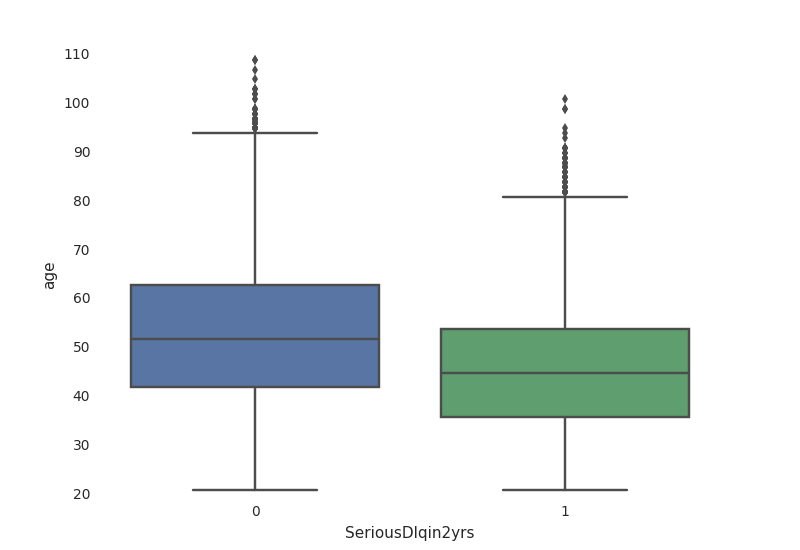

In [19]:
fig, ax = plt.subplots()

ax = sns.boxplot(x="SeriousDlqin2yrs", y="age", data = trainingSDF.toPandas())

display(fig)

Based on the cleaned age column, let's create an age banding column (bins) which correlate better to credit risk.

For this example, we are going to use the bins included in this paper: [figure in paper](https://www.researchgate.net/figure/Percentage-of-default-risk-among-different-age-groups_fig2_268345909)

In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def bandingFunction(age):
  if (age < 25):
    return '18-25'
  elif (age >= 25 and age < 30): 
    return '25-29'
  elif (age >= 30 and age < 35):
    return '30-34'
  elif (age >= 35 and age < 40):
    return '35-39'
  elif (age >= 40 and age < 45):
    return '40-44'
  elif (age >= 45 and age < 50):
    return '45-49'
  elif (age >= 50 and age < 55):
    return '50-54'
  elif (age >= 55 and age < 60):
    return '55-59'
  elif (age >= 60 and age < 65):
    return '60-64'
  elif (age >= 65 and age < 70):
    return '65-69'
  elif (age >= 70 and age < 75):
    return '70-74'
  elif (age >= 75): 
    return '75+'
  else: 
    return ''

age_banding_udf = udf(bandingFunction, StringType() )
trainingSDF = trainingSDF.withColumn('age_banding', age_banding_udf(trainingSDF.age))
trainingSDF = trainingSDF.drop('age')

temp_table_name = 'trainingSDF'

trainingSDF.createOrReplaceTempView(temp_table_name)

Let's now visualize the distribution.

In [23]:
%sql
select age_banding, count(*) as Frequency from trainingSDF group by age_banding order by age_banding

age_banding,Frequency
18-25,2074
25-29,6746
30-34,10419
35-39,12764
40-44,15799
45-49,18578
50-54,18199
55-59,17103
60-64,17125
65-69,11780


### MonthlyIncome variable

In credit scoring, the income of the individual - besides the other debt that he is into - is of greater importance than other things when it comes to the final decision.

Let's see how the distribution of this variable looks.

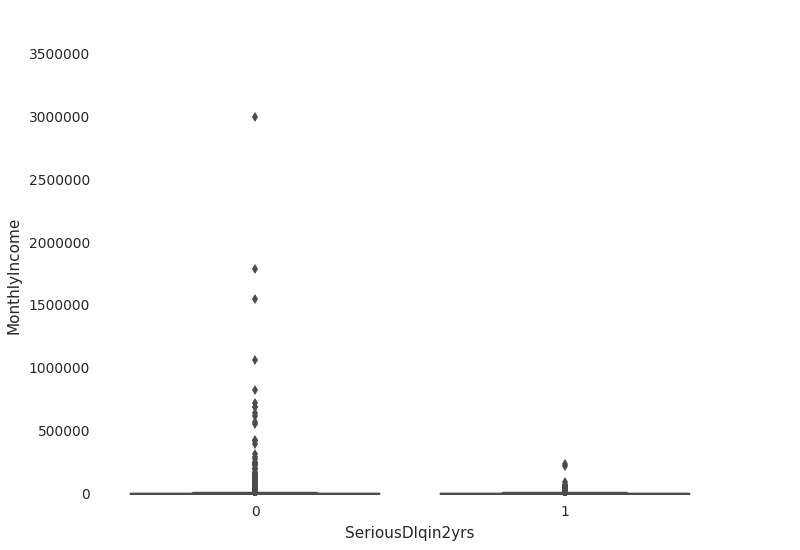

In [25]:
fig, ax = plt.subplots()

ax = sns.boxplot(x="SeriousDlqin2yrs", y="MonthlyIncome", data = trainingSDF.toPandas())

display(fig)

One thing is certain - people which have gone through issues usually have a lower income. However, it looks like the dataset contains really low values - like 5$ or less a month which is really odd.

For our reference, let's view the [Characteristics of Minimum Wage Workers in the US: 2010](https://www.bls.gov/cps/minwage2010.htm). In this article, it is stated that the prevailing Federal minimum wage was $7.25 per hour.

In this case, considering an individual would work on a full-time basis for 52 weeks straight in a year, that individual would earn **$7.25 X 40 hrs X 52 weeks** = **_$15,080_**.

This translates to approximately **_$1,256_** a month. For a part-time worker, this would mean a wage of **_$628_**. For an individual working only a quarter of the total time, that would mean a wage of only **_$314_**.

According to the [US Census Bureau, Current Population Survey 2016](https://en.wikipedia.org/wiki/Personal_income_in_the_United_States#cite_note-CPS_2015-2), 6.48% of people earned **_$2,500_** or less in a full year. This translates to only **_$208_** a month. Median personal income comes to about **_$31,099_** a year, which is about **_$2,592_** dollars a month.

Given all this information, let's do some more exploratory data analysis to see where this odd **MonthlyIncome** needs patching a bit.

Off the bat, there is weirdness in having NULL **MonthlyIncome** data, but being able to calculate **DebtRatio**.

In [28]:
%sql
select avg(DebtRatio), count(1) as Instances from trainingSDF where MonthlyIncome is null

avg(DebtRatio),Instances
1673.3965557835256,29731


We suppose that the ones gathering this data have replaced **NULL** in this column to 1 to be able to calculate the **DebtRatio** using the data about the **TotalDebt** of the individual they had. This will be need to be treated this way:
- impute the **NULL** values with the median of the dataset
- recalculate the **DebtRatio** given we know that the **TotalDebt** is currently equal for those individuals to the value of the **DebtRatio**

A **MonthlyIncome** between $1 and $7 is again a bit suspicious, let's see how it looks:

In [31]:
%sql
select MonthlyIncome, count(1) as Instances, avg(DebtRatio) from trainingSDF where MonthlyIncome between 1 and 7 group by MonthlyIncome order by 1

MonthlyIncome,Instances,avg(DebtRatio)
1,605,956.2776859504132
2,6,243.88888888833333
4,2,49.5
5,2,114.6666666835
7,1,12.5


Given the number of records where **MonthlyIncome** is equal to 1 is suspiciously high, we are going to impute it like we do for the **NULL** values. However, for the other values, there isn't just too much wrong data to draw any conclusions. If we extend the window up to 208:

In [33]:
%sql
select count(1) as Instance from trainingSDF where MonthlyIncome between 2 and 208

Instance
147


147 rows is still nothing compared to the whole dataset, so no point in patching these.

That's quite a lot of information, so let's wrap up what we are going to do:

For the specifics of this lab, we are going to consider that:
- observations with a MonthlyIncome of 1 will be processed to get the median MonthlyIncome
- observations with a MonthlyIncome of null will be processed to get the median MonthlyIncome

Given the **DebtRatio** has been computed as the overall **Debt** divided by the **MonthlyIncome**, we are going to regenerate the initial debt first so we can use it later to recompute the **DebtRatio** based on the then cleaned **MonthlyIncome**.

First, we save the initial **Debt** so we are able to recompute the updated DebtRatio afterwards.

In [37]:
from pyspark.sql import functions as F

def addInitialDebtColumn(df):
  df = df.withColumn(
                  'initialDebt',
                  F.when(
                      (((F.col('MonthlyIncome') >= 0) & (F.col('MonthlyIncome') <= 1)) | (F.col('MonthlyIncome').isNull())),
                      F.col('DebtRatio')
                  ).otherwise(
                      F.col('MonthlyIncome') * F.col('DebtRatio')
                  )
              )
  
  return df
  
trainingSDF = addInitialDebtColumn(trainingSDF)

In [38]:
display(trainingSDF)

Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_banding,initialDebt
1,1,0.766126609,2,0.802982129,9120,13,0,6,0,2,45-49,7323.19701648
2,0,0.957151019,0,0.121876201,2600,4,0,0,0,1,40-44,316.8781226
3,0,0.65818014,1,0.085113375,3042,2,1,0,0,0,35-39,258.91488675
4,0,0.233809776,0,0.036049682,3300,5,0,0,0,0,30-34,118.9639506
5,0,0.9072394,1,0.024925695,63588,7,0,1,0,0,45-49,1584.97509366
6,0,0.213178682,0,0.375606969,3500,3,0,1,0,1,70-74,1314.6243915
7,0,0.305682465,0,5710.0,null,8,0,3,0,0,55-59,5710.0
8,0,0.754463648,0,0.209940017,3500,8,0,0,0,0,35-39,734.7900595
9,0,0.116950644,0,46.0,null,2,0,0,0,null,25-29,46.0
10,0,0.189169052,0,0.606290901,23684,9,0,4,0,2,55-59,14359.393699284


After the initial **Debt** has been saved, we are good to start imputing the **MonthlyIncome** column:
- where the actual value is missing (is null), we use the Spark Imputer with a median strategy
- where the actual value is zero, we manually impute using the **NumPy** calculated median

In [40]:
from pyspark.ml.feature import Imputer
from pyspark.sql.types import DoubleType

def imputeMonthlyIncome(df):
  imputer = Imputer(
      inputCols = ['MonthlyIncome'],
      outputCols = ['imputed_MonthlyIncome'],
      strategy = 'median'
  )

  # Columns are required to either double or float by the Imputer...
  df = df.withColumn(
      'double_MonthlyIncome',
      df.MonthlyIncome.cast(DoubleType())
  ).drop('MonthlyIncome') \
   .withColumnRenamed('double_MonthlyIncome', 'MonthlyIncome')

  df = imputer.fit(df).transform(df).drop('MonthlyIncome')

  df = df.withColumnRenamed('imputed_MonthlyIncome', 'MonthlyIncome')

  # Addressing MonthlyIncome of 0
  incomeMedian = np.median(
                  df.select('MonthlyIncome')
                             .collect()
              )

  # Apply income median if the MonthlyIncome is 0
  df = df.withColumn('MonthlyIncome',
                                       F.when(
                                           (F.col('MonthlyIncome') == 1),
                                           incomeMedian
                                       ).otherwise(
                                           F.col('MonthlyIncome')
                                       )
                )
  
  return df

trainingSDF = imputeMonthlyIncome(trainingSDF)

Now that the **MonthlyIncome** variable has been imputed, let's recalculate a more correct **DebtRatio** based on the initial **Debt** we have saved previously.

In [42]:
def recalculateDebtRatio(df):
  df = df.withColumn(
                    'DebtRatio',
                    df.initialDebt/df.MonthlyIncome
                )
  
  return df

trainingSDF = recalculateDebtRatio(trainingSDF)

trainingSDF.createOrReplaceTempView(temp_table_name)

Let's see how many values in this column are actually exceeding the threshold of **1** now.

In [44]:
%sql
select count(1) from trainingSDF where DebtRatio > 1

count(1)
6249


From **35137** records down to **6480**. Let's see how it looks from a distribution point of view.

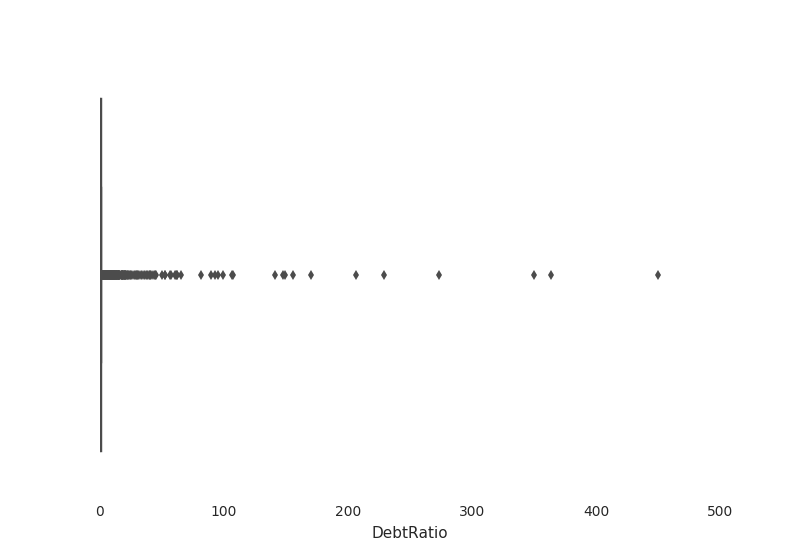

In [46]:
fig, ax = plt.subplots()

ax = sns.boxplot(x="DebtRatio", data = trainingSDF.toPandas())

display(fig)

It seems this values are going up to **x**. Individuals may exceed a **DebtRatio** of 1 whenever they are lending more than they are earning (and some people in difficult scenarios tend to do that).

Let's default the higher values to a threshold of **3**.

In [48]:
def defaultDebtRatioToThreshold(df):
  df = df.withColumn('DebtRatio',
                                       F.when(
                                           (F.col('DebtRatio') > 1.5),
                                           1.5
                                       ).otherwise(
                                           F.col('DebtRatio')
                                       )
                )
  
  return df

trainingSDF = defaultDebtRatioToThreshold(trainingSDF)

trainingSDF.createOrReplaceTempView(temp_table_name)

### RevolvingUtilizationOfUnsecuredLines variable
Let's understand how many values exceed 1 for this column and default them to this max value.

In [50]:
%sql
select count(1) from trainingSDF where RevolvingUtilizationOfUnsecuredLines > 1

count(1)
3321


**x** records have a **RevolvingUtilizationOfUnsecuredLines** value higher than 1. Given the total balance on credit cards and personal lines of credit is divided to the sum of credit limits, this should not exceed 1.

Let's view the distribution of it and then default the weird records to this threshold.

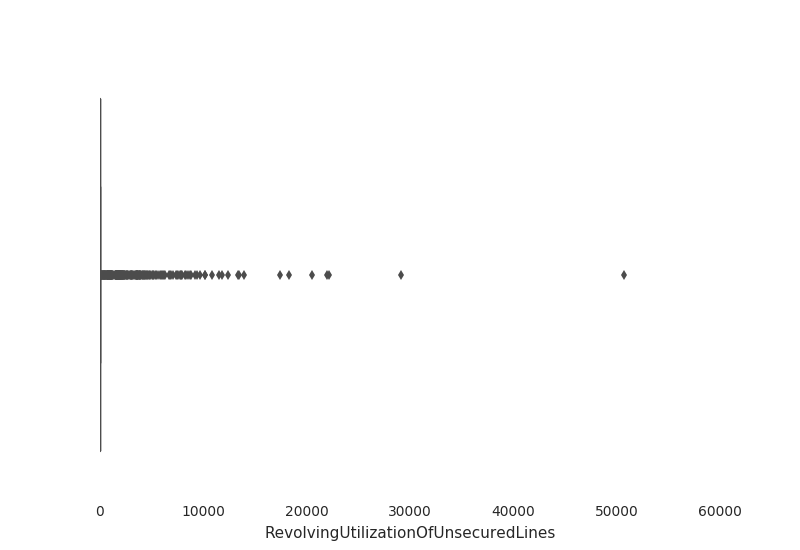

In [52]:
fig, ax = plt.subplots()

ax = sns.boxplot(x="RevolvingUtilizationOfUnsecuredLines", data = trainingSDF.toPandas())

display(fig)

In [53]:
def defaultRevolvingUtilizationToThreshold(df):
  df = df.withColumn('RevolvingUtilizationOfUnsecuredLines',
                                       F.when(
                                           (F.col('RevolvingUtilizationOfUnsecuredLines') > 1),
                                           1
                                       ).otherwise(
                                           F.col('RevolvingUtilizationOfUnsecuredLines')
                                       )
                )
  
  return df

trainingSDF = defaultRevolvingUtilizationToThreshold(trainingSDF)

trainingSDF.createOrReplaceTempView(temp_table_name)

### NumberOfDependents variable

Let's understand how many missing values this column has.

In [55]:
%sql
select count(1) from trainingSDF where NumberOfDependents is null

count(1)
3924


3924 missing values out of the total number of rows is not bad at all.

Let's see how the distribution of this variable looks. We will understand the mode from it and will be able to impute using it.

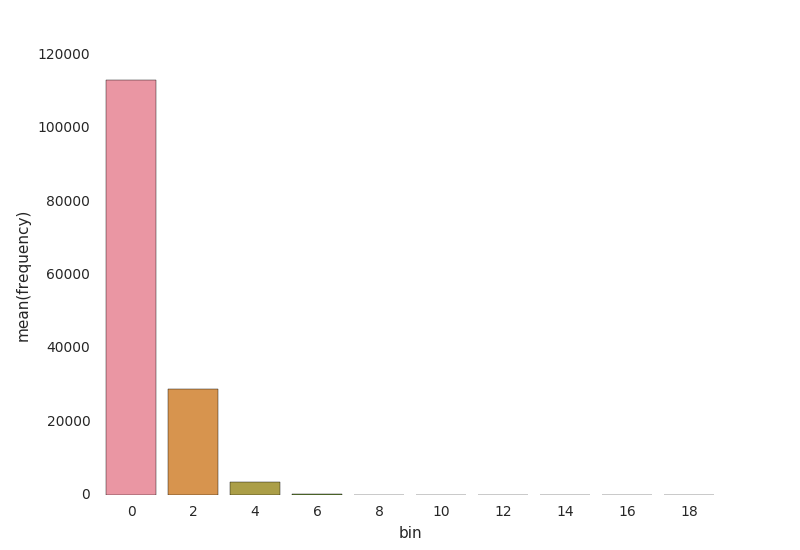

In [57]:
# spark.sql does not have any histogram method, however the RDD api does
dependents_histogram = trainingSDF.select('NumberOfDependents').rdd.flatMap(lambda x: x).histogram(10)

fig, ax = plt.subplots()

# the computed histogram needs to be loaded in a pandas dataframe so we will be able to plot it using sns
dependents_histogram_df = pd.DataFrame(
    list(zip(*dependents_histogram)), 
    columns=['bin', 'frequency']
)

ax = sns.barplot(x = "bin", y = "frequency", data = dependents_histogram_df)

display(fig)

We can tell from the barplot above that the mode of this column is 0. Let's impute the missing values with it.

In [59]:
def imputeNumberOfDependents(df):
  df = df.withColumn('NumberOfDependents',
                                       F.when(
                                           (F.col('NumberOfDependents').isNull()),
                                           0
                                       ).otherwise(
                                           F.col('NumberOfDependents')
                                       )
                )

  return df

trainingSDF = imputeNumberOfDependents(trainingSDF)
  
trainingSDF.createOrReplaceTempView(temp_table_name)

## Training and Evaluation

In order to train this problem, we are going to use the AutoML from the Azure Machine Learning Service SDK.

We will provide the cleansed training data to Azure ML which will test multiple types of algorithms in order to maximize a certain evaluation criteria we define. As per the [initial challenge from kaggle](https://www.kaggle.com/c/GiveMeSomeCredit), the criteria of choice is AUC (Area Under Curve).

After we are done, the best trained model will be evaluated against a separated dataset (the test dataset) in order to understand real _performance_.

### Training using AutoML from Azure

In order to get things going, we first initialize our Workspace...

In [61]:
subscription_id = "4bed8ea1-5766-44f7-9e13-f78ed002c0b9" #you should be owner or contributor
resource_group = "GlobalAINight-ML-RG" #you should be owner or contributor
workspace_name = "globalainight-ml-wksp" #your workspace name

import azureml.core

# Check core SDK version number - based on build number of preview/master.
print("SDK version:", azureml.core.VERSION)

from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (idna 2.1 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('idna<2.9,>=2.5'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.StepRun = azureml.pipeline.core:StepRun._from_dto with exception (idna 2.1 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('idna<2.9,>=2.5'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core:StepRun._from_reused_dto with exception (idna 2.1 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('idna<2.9,>=2.5'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core:PipelineRun._from_dto with exception (idna 2.1 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('idna<2.9,>=2.5'), {'requests'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (idna 2.1 (/databricks/python3/lib/python3.5/site-packages), Requirement.parse('idna<2.9,>=2.5'), {'requests'}).
SDK version: 1.0.60

In [62]:
ws = Workspace.from_config()

#if you use a different file name
#ws = Workspace.from_config(<full path>)

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: globalainight-ml-wksp
Azure region: northeurope
Subscription id: 4bed8ea1-5766-44f7-9e13-f78ed002c0b9
Resource group: GlobalAINight-ML-RG

And then we make sure we have all the important libraries in place.

In [64]:
import logging
import os
import random
import time

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

We prepare the experiment properties which will be provided once we issue a training request.

In [66]:
%scala
import scala.util.matching.Regex
val notebookPath = dbutils.notebook.getContext().notebookPath.get
dbutils.widgets.text("username", ("\\w+@".r findFirstIn notebookPath).get.dropRight(1))

import scala.util.matching.Regex
notebookPath: String = /Users/laurentiu.diaconu@softelligence.net/Global AI Night - Credit Scoring

In [67]:
# Choose a name for the experiment and specify the project folder.
experiment_base_name = 'automl-credit-scoring-'
notebook_username = dbutils.widgets.get("username")
experiment_suffix_name = notebook_username + "-" + str(random.randint(1000, 9999))

experiment_name = experiment_base_name + experiment_suffix_name
project_folder = './globalainight_projects/automl-credit-scring'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Out[ 25 ]: 
 
Experiment Name automl-credit-scoring-diaconu-2753 
Location northeurope 
Project Directory ./globalainight_projects/automl-credit-scring
Resource Group GlobalAINight-ML-RG 
SDK version 1.0.60 
Subscription ID 4bed8ea1-5766-44f7-9e13-f78ed002c0b9 
Workspace Name globalainight-ml-wksp

Enabling diagnostics to understand better what's going on.

In [69]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on.

We save the cleansed training data to CSV files in the DBFS and then we load it separately in two dataflows:
- **X_train**: contains **_only_** the training variables
- **Y_train**: contains **_only_** the result

In [71]:
#Automated ML requires a dataflow, which is different from dataframe.
#If your data is in a dataframe, please use read_pandas_dataframe to convert a dataframe to dataflow before usind dprep.

import azureml.dataprep as dataprep
training_sdf = trainingSDF
training_sdf = training_sdf.drop("Idx", "initialDebt")

training_sdf \
.drop("SeriousDlqin2yrs") \
.toPandas() \
.to_csv('/dbfs/FileStore/data/constant-scoring-training-vars.csv')

training_sdf \
.select("SeriousDlqin2yrs") \
.toPandas() \
.to_csv('/dbfs/FileStore/data/constant-scoring-training-res.csv')

X_train = dataprep.read_csv(path = '/dbfs/FileStore/data/constant-scoring-training-vars.csv', separator = ',')
X_train = X_train.drop_columns("Column1")

Y_train = dataprep.read_csv(path = '/dbfs/FileStore/data/constant-scoring-training-res.csv', separator = ',')
Y_train = Y_train.drop_columns("Column1")

Checking to make sure we have data inside.

In [73]:
X_train.head(5)

Out[ 28 ]: 
 RevolvingUtilizationOfUnsecuredLines ... MonthlyIncome
0 0.766126609 ... 9120.0 
1 0.957151019 ... 2600.0 
2 0.65818014 ... 3042.0 
3 0.233809776 ... 3300.0 
4 0.9072394 ... 63588.0 

[5 rows x 10 columns]

In [74]:
Y_train.head(5)

Out[ 29 ]: 
 SeriousDlqin2yrs
0 1 
1 0 
2 0 
3 0 
4 0

AutoML in Azure may be configured by passing multiple properties through the [AutoML Config](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.automlconfig?view=azure-ml-py).

We are interested in the following:

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**spark_context**|Spark Context object. for Databricks, use spark_context=sc|
|**max_concurrent_iterations**|Maximum number of iterations to execute in parallel. This should be <= number of worker nodes in your Azure Databricks cluster.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**preprocess**|set this to True to enable pre-processing of data eg. string to numeric using one-hot encoding|
|**exit_score**|Target score for experiment. It is associated with the metric. eg. exit_score=0.995 will exit experiment after that|

In [76]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 10,
                             iterations = 15,
                             n_cross_validations = 10,
                             max_concurrent_iterations = 1, #change it based on number of worker nodes
                             verbosity = logging.INFO,
                             spark_context=sc, #databricks/spark related
                             X = X_train, 
                             y = Y_train,
                             path = project_folder,
                             preprocess = True,
                             enable_voting_ensemble = True,
                             enable_stack_ensemble = True)

We are now ready to submit a new run for our experiment.

In [78]:
local_run = experiment.submit(automl_config, show_output = True) # for higher runs please use show_output=False and use the below

Running on ADB cluster experiment automl-credit-scoring-diaconu-2753.
Parent Run ID: AutoML_d678ff3f-fc8d-4127-886e-55843799e269

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST
 0 MaxAbsScaler LightGBM 0:00:27 0.8106 0.8106
 1 MaxAbsScaler SGD 0:00:22 0.8241 0.8241
 2 StandardScalerWrapper LightGBM 0:00:23 0.8223 0.8241
 3 MaxAbsScaler RandomForest 0:00:25 0.7252 0.8241
 4 MaxAbsScaler SGD 0:00:29 0.8165 0.8241
 5 MaxAbsScaler ExtremeRandomTrees 0:00:27 0.6969 0.8241
 6 MaxAbsScaler SGD 0:00:36 0.8221 0.8241
 7 StandardScalerWrapper ExtremeRandomTrees 0:00:37 0.7280 0.8241
 8 MaxAbsScaler RandomForest 0:00:27 0.7196 0.8241
 9 MaxAbsScaler LightGBM 0:00:23 0.8209 0.8241
 10 MaxAbsScaler BernoulliNaiveBayes 0:00:20 0.8247 0.8247
 11 MaxAbsScaler SGD 0:00:19 0.7974 0.8247
 12 MaxAbsScaler LightGBM 0:00:32 0.7551 0.8247
 13 VotingEnsemble 0:01:05 0.8291 0.8291
 14 StackEnsemble 0:01:51 0.8280 0.8291

And once the run is finished, we are able to retrieve the best model as per the metric we have configured.

In [80]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-credit-scoring-diaconu-2753,
Id: AutoML_d678ff3f-fc8d-4127-886e-55843799e269_13,
Type: None,
Status: Completed)
Pipeline(memory=None,
 steps=[('datatransformer',
 DataTransformer(enable_feature_sweeping=None,
 feature_sweeping_timeout=None,
 is_onnx_compatible=None, logger=None,
 observer=None, task=None)),
 ('prefittedsoftvotingclassifier',
 PreFittedSoftVotingClassifier(classification_labels=None,
 estimators=[('10',
 Pipeline(memory=None,
 steps=[('maxabsscaler',
 MaxAbsScaler(c...
 fit_intercept=True,
 l1_ratio=0.7755102040816326,
 learning_rate='constant',
 loss='hinge',
 max_iter=1000,
 n_jobs=1,
 penalty='none',
 power_t=0.7777777777777777,
 random_state=None,
 tol=0.001))],
 verbose=None))],
 flatten_transform=None,
 weights=[0.066666666666666666,
 0.066666666666666666,
 0.26666666666666666,
 0.20000000000000001,
 0.26666666666666666,
 0.13333333333333333]))],
 verbose=None)
Y_transformer(['LabelEncoder', LabelEncoder()])

**Portal URL for Monitoring Runs**

The following will provide a link to the web interface to explore individual run details and status.

In [82]:
displayHTML("<a href={} target='_blank'>Your experiment in Azure Portal: {}</a>".format(local_run.get_portal_url(), local_run.id))

Your experiment in Azure Portal: AutoML_d678ff3f-fc8d-4127-886e-55843799e269

### Evaluating the best model from AutoML against real unseen data

Now that we are done with training, we can move forward in evaluating how well this model will actually do on real data.

For this, we are going to import a new dataset, take it through the same transformations and have the model predict the result.

In [84]:
# Test data - file location and type
test_file_location = "/FileStore/tables/constantscoring/cs_test-31b97.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
testSDF = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(test_file_location)

temp_table_name = "testSDF"

# Make the dataframe available in the SQL context
testSDF.createOrReplaceTempView(temp_table_name)

Once the data has been loaded, we have to get this validation dataset through the same pipeline of transformations.

In [86]:
#testSDF = imputeAgeWithMedian(testSDF)

#testSDF = testSDF.withColumn('age_banding', age_banding_udf(testSDF.age))
#testSDF = testSDF.drop('age')

#testSDF = addInitialDebtColumn(testSDF)
testSDF = imputeMonthlyIncome(testSDF)
testSDF = recalculateDebtRatio(testSDF)
#testSDF = defaultDebtRatioToThreshold(testSDF)
#testSDF = defaultRevolvingUtilizationToThreshold(testSDF)
testSDF = imputeNumberOfDependents(testSDF)

# Make the dataframe available in the SQL context
testSDF.createOrReplaceTempView(temp_table_name)
display(testSDF)

Idx,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age_banding,initialDebt,MonthlyIncome
1,0,0.88551908,0,0.177512717,4,0,0,0,0,40-44,1011.8224869,5700.0
2,0,0.463295269,0,0.527236928,15,0,4,0,2,55-59,4819.472758848,9141.0
3,0,0.043275036,0,0.687647522,12,0,1,0,2,55-59,3495.312354326,5083.0
4,0,0.280308229,1,0.925960637,7,0,2,0,0,35-39,2963.0740384,3200.0
5,0,0.9999999,0,0.019917227,4,0,0,0,1,25-29,76.980082355,3865.0
6,0,0.509791452,0,0.342429365,4,0,0,0,1,60-64,1417.6575711,4140.0
7,0,0.587778161,0,null,5,0,0,0,3,50-54,1048.0,0.0
8,0,0.046148938,1,0.3691702,8,0,1,0,1,75+,1218.6308302,3301.0
9,0,0.013527027,0,0.3748148148148148,4,0,1,0,0,65-69,2024.0,5400.0
10,0,0.9999999,98,null,0,98,0,98,0,18-25,0.0,0.0


In [87]:
# Save the actual result in a separate dataframe and predict the model result
import pyspark.sql.functions as f

resultsSDF = testSDF.select("Idx", "SeriousDlqin2yrs")
temp_table_name = "resultsSDF"

# Make the dataframe available in the SQL context
resultsSDF.createOrReplaceTempView(temp_table_name)

testSDF = testSDF.drop("SeriousDlqin2yrs", "initialDebt")

predictions = fitted_model.predict(testSDF.drop("Idx").toPandas())

The raw results... which are not of any use for now.

In [89]:
predictionsSDF = spark.createDataFrame(pd.DataFrame(predictions, columns=["SeriousDlqin2yrs_pred"]).reset_index(drop = False))

from pyspark.sql.types import IntegerType

# Change column to be int
predictionsSDF = predictionsSDF.withColumn(
    'int_SeriousDlqin2yrs_pred',
    predictionsSDF.SeriousDlqin2yrs_pred.cast(IntegerType())
).drop('SeriousDlqin2yrs_pred') \
 .withColumnRenamed('int_SeriousDlqin2yrs_pred', 'SeriousDlqin2yrs_pred')

display(predictionsSDF)

index,SeriousDlqin2yrs_pred
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,1


In order to make sense of the results, we need to:
- join the **predictions** with the initial dataset containing only the independent variables
- join the actual **results** back to the dataset obtained at the previous step

In [91]:
testsAndPredictionsSDF = testSDF.join(predictionsSDF, testSDF.Idx == predictionsSDF.index+1)

comparisonSDF = testsAndPredictionsSDF.join(resultsSDF, testsAndPredictionsSDF.Idx == resultsSDF.Idx)

comparisonSDF.createOrReplaceTempView("comparisonSDF")

### Metrics
Once all the joining has been finished, we can look at a raw confusion matrix.

In [93]:
%sql
select SeriousDlqin2yrs, SeriousDlqin2yrs_pred, count(1) as Occurences 
  from comparisonSDF 
group by SeriousDlqin2yrs, SeriousDlqin2yrs_pred 
order by SeriousDlqin2yrs, SeriousDlqin2yrs_pred

SeriousDlqin2yrs,SeriousDlqin2yrs_pred,Occurences
0,0,99103
0,1,695
1,0,581
1,1,1124


Let's calculate the classic classification metrics:
- accuracy
- recall
- precision
- AUC

Let's also plot the ROC curve.

In [95]:
evaluationDF = comparisonSDF.select("SeriousDlqin2yrs", "SeriousDlqin2yrs_pred").toPandas()

In [96]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

print("Accuracy score is: {}".format(accuracy_score(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)))
print("Recall score is: {}".format(recall_score(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)))
print("Precision score is: {}".format(precision_score(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)))
print("F1 score is: {}".format(f1_score(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)))
print("AUC is: {}".format(roc_auc_score(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)))

Accuracy score is: 0.9874289429869068
Recall score is: 0.6592375366568914
Precision score is: 0.6179219351291919
F1 score is: 0.637911464245176
AUC is: 0.8261367346203554

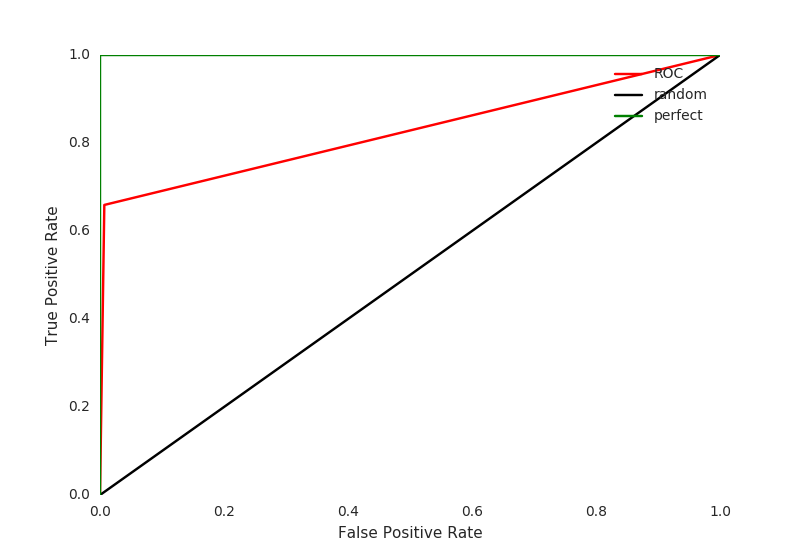

In [97]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(evaluationDF.SeriousDlqin2yrs.values, evaluationDF.SeriousDlqin2yrs_pred.values)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax = plt.plot(fpr, tpr, 'r-', label = 'ROC')
ax = plt.plot([0,1], [0,1], 'k-', label='random')
ax = plt.plot([0,0,1,1], [0,1,1,1], 'g-', label='perfect')
ax = plt.legend()
ax = plt.xlabel('False Positive Rate')
ax = plt.ylabel('True Positive Rate')

display(fig)